In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


def extract_last_4_chars(value):
    return value[-4:]


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [3]:
raw_data = pd.read_csv("GDP_Dataset.csv")

raw_data['date'] = raw_data['date'].apply(extract_last_4_chars)

raw_data["date"] = raw_data["date"].astype(int)

mean_val = raw_data[' Growthannualchange'].mean()
raw_data[' Growthannualchange'].fillna(mean_val, inplace=True)

raw_data.head()

,date,GDP,Per Capita,Growthannualchange
0,1960,3.749265,81.5869,5.059571
1,1961,4.118648,87.5174,5.987300
2,1962,4.310164,89.4933,4.482900
3,1963,4.630827,93.8839,8.688800
4,1964,5.204956,102.9612,7.569800


In [6]:
series = raw_data[" GDP"].values
time = raw_data["date"].values

In [9]:
split_time = 56

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [37]:
window_size = 40
batch_size = 8
shuffle_buffer_size = 56

In [38]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [39]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 40, 1)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [40]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2/2 [==============================] - 4s 64ms/step - loss: 70.7870 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 38ms/step - loss: 70.7557 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 70.7172 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 70.5813 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 24ms/step - loss: 70.4789 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 14ms/step - loss: 70.3720 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 70.1057 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 24ms/step - loss: 69.9243 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 27ms/step - loss: 69.6584 - lr: 2.5119e-08
Epoch 10/100
2/2 [==============================] - 0s 24ms/step - loss: 69.3984 - lr: 2.8184e-08
Epoch 11/100
2/2 [=======================

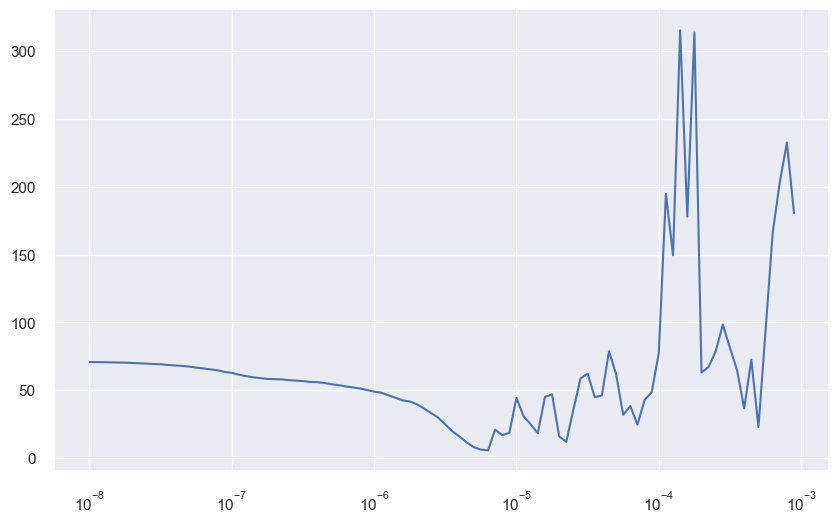

In [41]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

In [42]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

learning_rate = 3e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
2/2 [==============================] - 4s 51ms/step - loss: 97.1022 - mae: 97.6022
Epoch 2/500
2/2 [==============================] - 0s 41ms/step - loss: 55.7370 - mae: 56.2370
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 56.8466 - mae: 57.3466
Epoch 4/500
2/2 [==============================] - 0s 27ms/step - loss: 71.3789 - mae: 71.8789
Epoch 5/500
2/2 [==============================] - 0s 32ms/step - loss: 73.0378 - mae: 73.5378
Epoch 6/500
2/2 [==============================] - 0s 37ms/step - loss: 61.0118 - mae: 61.5118
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 43.3965 - mae: 43.8965
Epoch 8/500
2/2 [==============================] - 0s 22ms/step - loss: 46.6013 - mae: 47.1013
Epoch 9/500
2/2 [==============================] - 0s 16ms/step - loss: 49.3293 - mae: 49.8248
Epoch 10/500
2/2 [==============================] - 0s 24ms/step - loss: 37.7735 - mae: 38.2735
Epoch 11/500
2/2 [==============================]

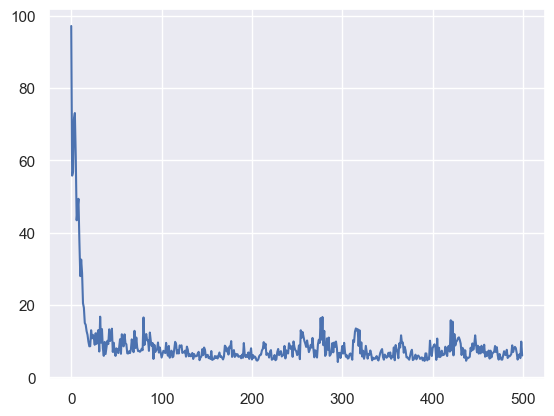

In [43]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [44]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

1/1 [==============================] - 0s 72ms/step


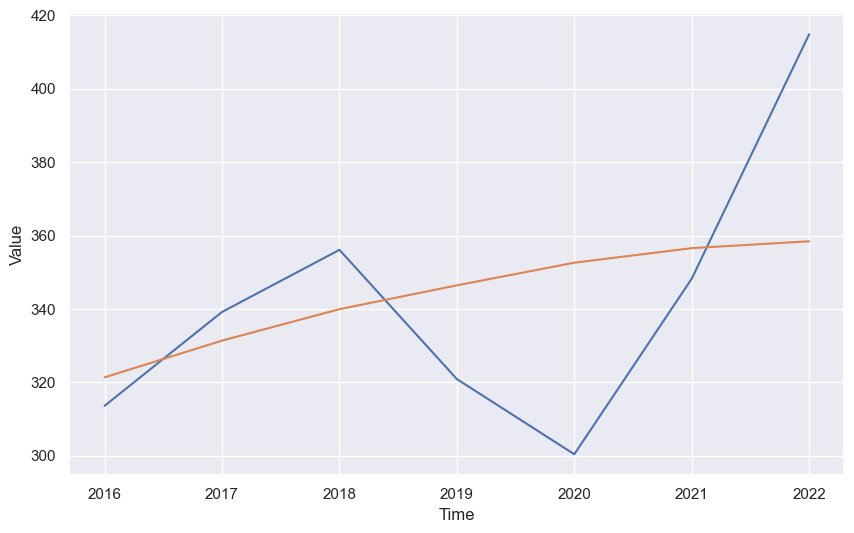

In [51]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

results = results + 50

plot_series(time_valid, (x_valid, results))

1/1 [==============================] - 0s 24ms/step


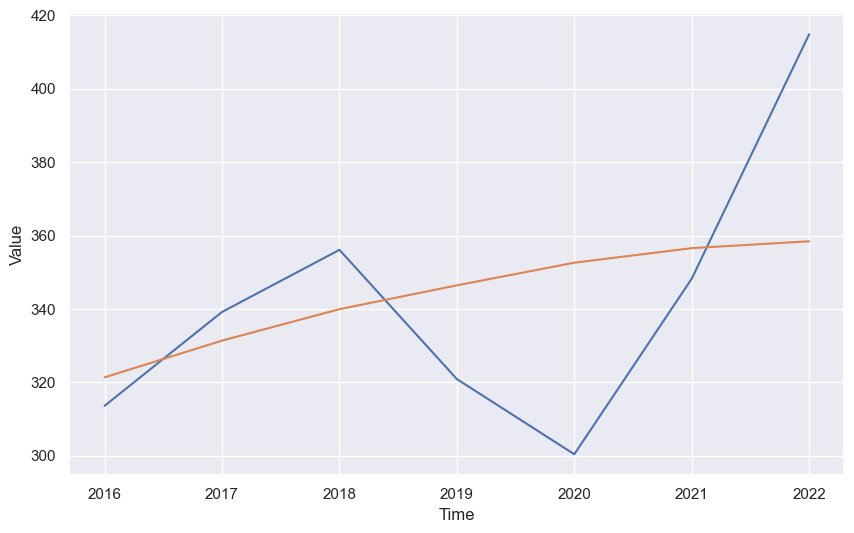

In [52]:
forecast = []
forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

results = np.array(forecast).squeeze()
results +=50

plot_series(time_valid, (x_valid, results))

In [53]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1001.74475
24.889292
